In [66]:
import torch
import gpytorch
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

IMG_SIZE = (50, 100)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def map_to_cylinder(points):
    return torch.stack((torch.cos(2 * torch.pi * points[:, 1]), torch.sin(2 * torch.pi * points[:, 1]), torch.pi * points[:, 0]), -1)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, RBF_lengthscale_constraint=None, Periodic_lengthscale_constraint=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.likelihood = likelihood
        self.mean_module = gpytorch.means.ZeroMean()
        self.RBF = gpytorch.kernels.RBFKernel(ard_num_dims=3, lengthscale_constraint=RBF_lengthscale_constraint)
        self.Periodic = gpytorch.kernels.PeriodicKernel(ard_num_dims=3, lengthscale_constraint=Periodic_lengthscale_constraint)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.RBF) + gpytorch.kernels.ScaleKernel(self.Periodic)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def start_training(self, train_x, train_y, num_iter=100, need_plot=True):
        self.train()
        self.likelihood.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        my_loss = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)

        history = {"loss": [], 
                "lengthscale": [],
                "noise": []}

        for _ in tqdm(range(num_iter), desc='Training'):
            optimizer.zero_grad()
            output = self(train_x)
            loss = -my_loss(output, train_y)
            loss.backward()
            history["loss"].append(loss.item())
            # lengthscale = self.covar_module.base_kernel.lengthscale.item()
            # history["lengthscale"].append(lengthscale)
            # history["noise"].append(self.likelihood.noise.item())
            optimizer.step()
            
        if need_plot:
            plt.figure(figsize=(10, 5))
            plt.plot(history["loss"])
            plt.title(f'Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
        
    def predict(self, data, num_samples=16, need_plot=True):
        self.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            sampled_preds = self(data.to(device)).rsample(sample_shape=torch.Size((num_samples,)))

        if need_plot:
            n = int(torch.sqrt(num_samples))
            _, axs = plt.subplots(n, n, figsize=(20, 10))
            plt.suptitle(f'Samples')
            for i in range(n):
                for j in range(n):
                    axs[i, j].imshow(sampled_preds[i*n+j].cpu().detach().numpy().reshape(IMG_SIZE), cmap='PuOr')
                    axs[i, j].contour(sampled_preds[i*n+j].cpu().detach().numpy().reshape(IMG_SIZE), levels=0, colors='k')
                    axs[i, j].axis('off')
            plt.show()

        return sampled_preds

In [19]:
dx, dy = 1 / IMG_SIZE[0], 1 / IMG_SIZE[1]
xv, yv = torch.meshgrid(torch.linspace(0, 1-dx, IMG_SIZE[0]), torch.linspace(0, 1-dy, IMG_SIZE[1]), indexing="ij")
x_test = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1)
x_test = map_to_cylinder(x_test)

In [20]:
xv, yv = torch.meshgrid(torch.linspace(0, 1, IMG_SIZE[0]), torch.linspace(0, 1, IMG_SIZE[1]), indexing="ij")
x_test = torch.cat((
    xv.contiguous().view(xv.numel(), 1),
    yv.contiguous().view(yv.numel(), 1)),
    dim=1)

x_train = torch.cat((x_test[:5*IMG_SIZE[1], :], x_test[-5*IMG_SIZE[1]:, :]), 0)

x_train = map_to_cylinder(x_train)
x_test = map_to_cylinder(x_test)
y_train = torch.cat((torch.ones(5*IMG_SIZE[1]), -torch.ones(5*IMG_SIZE[1])))

Training: 100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


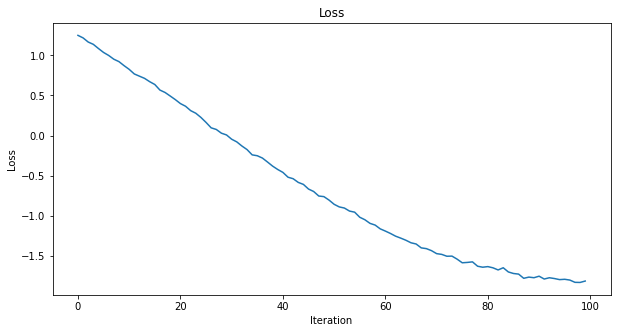

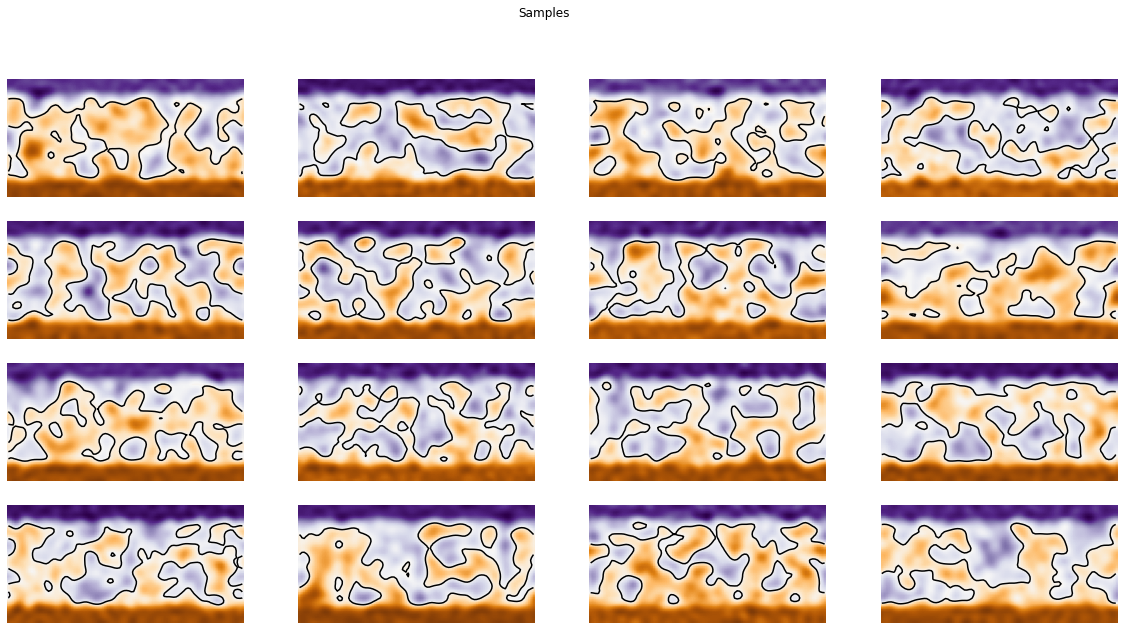

In [21]:
RBF_lengthscale_right = Interval(0.01, 0.15)
Periodic_lengthscale_right = Interval(0.01, 0.15)



likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood, RBF_lengthscale_constraint=RBF_lengthscale_right, Periodic_lengthscale_constraint=Periodic_lengthscale_right)

model = model.to(device)
x_train = x_train.to(device)
y_train = y_train.to(device)

model.start_training(x_train, y_train, num_iter=100, need_plot=True)
samples = model.predict(x_test.to(device))

In [67]:
samples = model.predict(x_test.to(device), num_samples=1000, need_plot=False)
samples = samples.view(-1, *IMG_SIZE).cpu().detach()
eps = 0.5e-1
samples[samples.abs() < eps] = 0
samples[samples.abs() >= eps] = 1

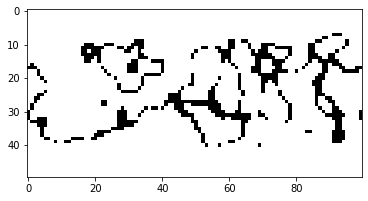

In [68]:
plt.imshow(samples[0], cmap='gray')

In [69]:
samples = model.predict(x_test.to(device), num_samples=1000, need_plot=False)
samples = samples.view(-1, *IMG_SIZE).cpu().detach()



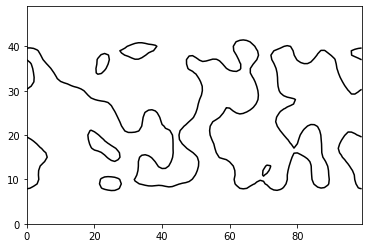

In [73]:
plt.contour(samples[0], levels=0, colors='k')
plt.savefig('contour.png')

In [85]:
os.makedirs('CloC dataset', exist_ok=True)

for i, sample in enumerate(samples):
    plt.contour(sample, levels=0, colors='k')
    plt.axis('off')
    plt.savefig(f'CloC dataset/{i:04}.png', bbox_inches='tight', pad_inches=0, facecolor='white')
    # dont display image
    plt.clf()


<Figure size 432x288 with 0 Axes>

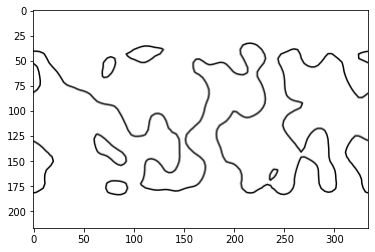

In [86]:
# open image from CloC dataset
plt.imshow(plt.imread('CloC dataset/0000.png'), cmap='gray')

In [88]:
# open image from CloC dataset as array
a = plt.imread('CloC dataset/0000.png')
a.shape



(217, 334, 4)

In [89]:
import numpy as np
from PIL import Image, ImageOps

a = np.array(ImageOps.grayscale(Image.open('CloC dataset/0000.png'))).astype(int)
a.shape

(217, 334)

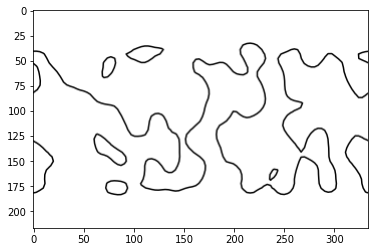

In [90]:
plt.imshow(a, cmap='gray')